<a href="https://colab.research.google.com/github/JRKagumba/2D-video-based-exercise-classification/blob/main/notebooks/03_XGB_Model_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mount Drive

In [125]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Install Libraries

In [126]:
!pip install cesium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [127]:
import os
import cesium
import xgboost as xgb
import numpy as np
import pandas as pd

from cesium import featurize as ft
import matplotlib.pyplot as plt

from cesium import featurize as ft
import matplotlib.pyplot as plt

### Initialize Data Scturctures and Functions

In [128]:
PROJ_WORKOUTS_ROOT = os.path.join('/content/gdrive/MyDrive/ColabNotebooks/BiomechanicsAnalysis/___WORKOUTS/data/tests/processed')

workout_types = os.listdir(PROJ_WORKOUTS_ROOT)

joint_angles_list = ['L_ELB',	'R_ELB',
                     'L_SHO','R_SHO',
                     'L_HIP','R_HIP',
                     'L_KNE','R_KNE']

data_dict = {
    'burpees_test':[],
    'jumping_jacks_test':[],
    'mountain_climbers_test':[],
    'pushups_test':[],
    'squats_test':[],
    'other_test' : []
}




### Load in Test DataFrames

In [129]:
for workout_type in workout_types:
    workout_samples = os.listdir(os.path.join(PROJ_WORKOUTS_ROOT, workout_type)) 
    for sample in workout_samples:
        sample_csv_path = os.path.join(PROJ_WORKOUTS_ROOT, workout_type, sample, f'{sample}_joint_angles.csv')

        df = pd.read_csv(sample_csv_path)
        data_dict[workout_type].append(df)

### Convert Test DataFrames to Feature Set DataFrames

In [130]:
JA_df_dict = {}

for joint_angle in joint_angles_list:

    dataframe_lst = []

    for key, value_lst in data_dict.items():
        for df in value_lst:
            dataframe_lst.append(
                {   
                'times' : df.index.to_numpy(), 
                'values' : df[joint_angle].to_numpy(), 
                'classes' : key
                }
            )

    JA_df_dict[joint_angle] = pd.DataFrame(dataframe_lst)

### Convert all Dataframes to Dicts (this is the format cesium likes for feature generation)

In [131]:
for key in JA_df_dict.keys():

    JA_df_dict[key] = JA_df_dict[key].to_dict()

    times = [value for value in JA_df_dict[key]['times'].values()]
    values = [value for value in JA_df_dict[key]['values'].values()]
    classes = np.array([value for value in JA_df_dict[key]['classes'].values()])


    JA_df_dict[key]['times'] = times
    JA_df_dict[key]['values'] = values
    JA_df_dict[key]['classes'] = classes

### Create a dict of features for each joint angle time series set

In [132]:
features_to_use = [    
    "amplitude",
    "percent_beyond_1_std",
    "maximum",
    "max_slope",
    "median",
    "median_absolute_deviation",
    "percent_close_to_median",
    "minimum",
    "skew",
    "std",
    "weighted_average"]

features_df_dict = {}

for key in JA_df_dict.keys():

    features_df_dict[key] = ft.featurize_time_series(times=JA_df_dict[key]['times'],
                                              values=JA_df_dict[key]["values"],
                                              errors=None,
                                              features_to_use=features_to_use,
                                              scheduler=None)
    
    features_df_dict[key]['classes'] = JA_df_dict[key]['classes']
    features_df_dict[key].columns =  features_df_dict[key].columns.droplevel(-1)

features_df_dict['L_ELB'].head(3)

feature,amplitude,percent_beyond_1_std,maximum,max_slope,median,median_absolute_deviation,percent_close_to_median,minimum,skew,std,weighted_average,classes
0,87.721484,0.210863,175.474049,105.679419,147.797260,21.631930,0.351438,0.031081,-1.039510,46.315788,126.740489,burpees_test
1,88.687373,0.329032,179.894833,165.427674,155.408061,20.931954,0.365591,2.520087,-0.563739,62.550092,117.715181,burpees_test
2,86.951540,0.287190,179.978259,120.040066,168.104734,10.773445,0.613636,6.075179,-0.771645,60.925121,129.081233,burpees_test


### Load Models

In [133]:
import pickle
MODELS_ROOT_PATH = '/content/gdrive/MyDrive/ColabNotebooks/BiomechanicsAnalysis/___WORKOUTS/models/xgb'



json_joint_model = {}
pkle_joint_model = {}


for joint in joint_angles_list:

    json_model_path = os.path.join(MODELS_ROOT_PATH, f'{joint}_model.json')
    pkle_model_path = os.path.join(MODELS_ROOT_PATH, f'{joint}_model.pkl')



    pkle_joint_model[joint] = pickle.load(open(pkle_model_path, "rb"))



    model_xgb = xgb.XGBClassifier()
    # model_xgb = xgb.Booster()
    model_xgb.load_model(json_model_path)

    json_joint_model[joint] = model_xgb


    
# joint_model['L_ELB'].best_ntree_limit

In [134]:
X = features_df_dict['R_SHO'].iloc[:, :-1].values
y = features_df_dict['R_SHO'].iloc[:, -1].values

In [135]:
print(X[0].reshape(1, 11), y[0])
pkle_joint_model['R_SHO'].predict(X[0].reshape(1, 11))

[[ 89.29443773   0.35463259 179.4373727  114.3942436   67.58863914
   28.79611356   0.34824281   0.84849724   0.22199602  36.78055473
   71.38283947]] burpees_test


array(['burpees'], dtype=object)

In [136]:
actual  = [exercise[:-5] for exercise in y]
predicted = [pkle_joint_model['R_SHO'].predict(X[index].reshape(1, 11))[0] for index in range(len(X)-1)]

In [137]:
# print(actual)
# print(predicted)


df = pd.DataFrame(list(zip(actual, predicted)),
               columns =['Actual', 'Predicted'])

In [138]:
non_other_df = df[df['Actual'] != 'other']

print(non_other_df[non_other_df['Actual']==non_other_df['Predicted']].count())

Actual       11
Predicted    11
dtype: int64


In [139]:
sum(non_other_df['Actual']==non_other_df['Predicted'])

len(non_other_df)

22

### Predicting Scores Per Joint

In [147]:
joint_scores_dict = {}

for joint in joint_angles_list:
    
    X = features_df_dict[joint].iloc[:, :-1].values
    y = features_df_dict[joint].iloc[:, -1].values

    actual  = [exercise[:-5] for exercise in y]
    predicted = [pkle_joint_model[joint].predict(X[index].reshape(1, 11))[0] for index in range(len(X)-1)]

    df = pd.DataFrame(list(zip(actual, predicted)),columns =['Actual', 'Predicted'])
    non_other_df = df[df['Actual'] != 'other']

    joint_scores_dict[joint] = [round(sum(non_other_df['Actual']==non_other_df['Predicted'])/len(non_other_df), 2)]

joint_scores_df = pd.DataFrame(joint_scores_dict).T

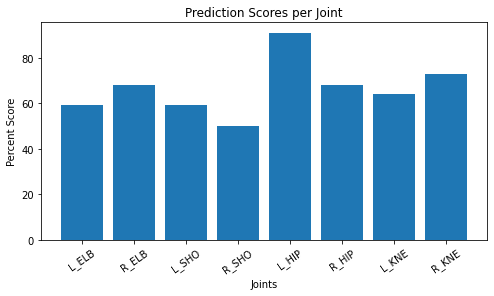

In [164]:
plt.figure(figsize=(8,4))
plt.bar(joint_scores_df.index, (joint_scores_df[0])*100)
plt.title("Prediction Scores per Joint")

plt.xlabel("Joints")
plt.ylabel("Percent Score")
plt.xticks(rotation="35")

plt.show()

### Predicting Scores per Exercise

In [158]:
exercises_lst =  ['burpees', 'jumping_jacks', 'mountain_climbers', 'pushups','squats']
exercises_scores_dict = {exercise : [0,0] for exercise in exercises_lst}


for exercise in exercises_lst:
    for joint in joint_angles_list:
        
        X = features_df_dict[joint].iloc[:, :-1].values
        y = features_df_dict[joint].iloc[:, -1].values

        actual  = [exercise[:-5] for exercise in y]
        predicted = [pkle_joint_model[joint].predict(X[index].reshape(1, 11))[0] for index in range(len(X)-1)]

        df = pd.DataFrame(list(zip(actual, predicted)),columns =['Actual', 'Predicted'])
        non_other_df = df[df['Actual'] != 'other']

        exercise_df = non_other_df[non_other_df['Actual'] == exercise]
        exercises_scores_dict[exercise][0] += sum(exercise_df['Actual']==exercise_df['Predicted'])
        exercises_scores_dict[exercise][1] += len(exercise_df)
        
 

exercises_scores_dict = {key : [ round(x/value[1],2) for x in value] 
                         for key, value in exercises_scores_dict.items()}

exercises_scores_df = pd.DataFrame(exercises_scores_dict).T

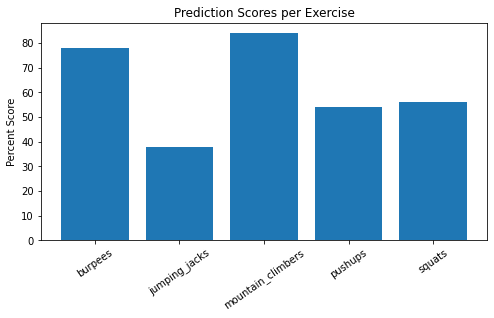

In [165]:

plt.figure(figsize=(8,4))
plt.bar(exercises_scores_df.index, (exercises_scores_df[0])*100)
plt.title("Prediction Scores per Exercise")

plt.ylabel("Percent Score")
plt.xticks(rotation="35")

plt.show()

### Ensembling Predictions per Joint for Final Prediction

In [162]:
joint_votes_dict = {exercise_index : [[],''] for exercise_index in range(22)}

for exercise_index in range(22):
    for joint in joint_angles_list:
        
        X = features_df_dict[joint].iloc[:, :-1].values
        y = features_df_dict[joint].iloc[:, -1].values

        predicted = pkle_joint_model[joint].predict(X[exercise_index].reshape(1, 11))[0] 
        actual  = y[exercise_index][:-5]

        joint_votes_dict[exercise_index][0].append(predicted) 
        joint_votes_dict[exercise_index][1]=actual

    joint_votes_dict[exercise_index][0] = max(joint_votes_dict[exercise_index][0], key=joint_votes_dict[exercise_index][0].count)

In [163]:
df = pd.DataFrame(joint_votes_dict).T.rename(columns={0: "Predicted", 1: "Actual"})

round(len(df[df['Predicted'] == df['Actual']])/len(df), 2)

0.86

Looks like creating a final prediction based on each individual joint's prediction is pretty good. The above prediciton when ensembling each joint's prediction is about 86% accurate on the test set.


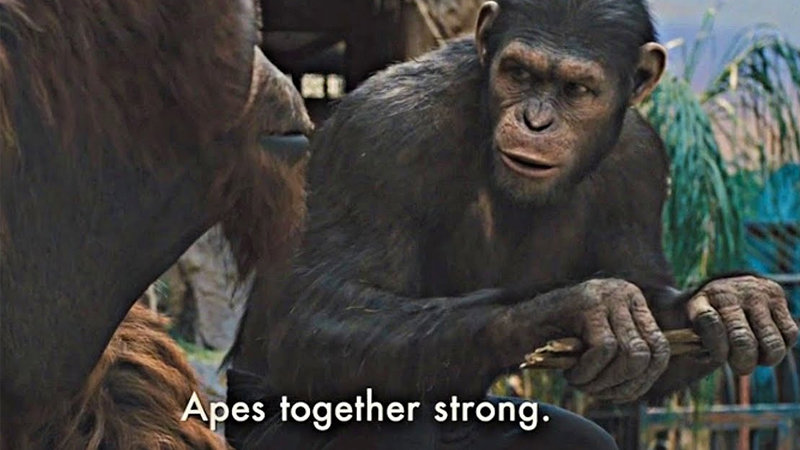